In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../feature_selection.csv')
df.head()

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,...,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,dec,koi_disposition
0,101.110701,0.000953,-0.000953,0.008060,-0.008060,0.0460,0.2100,-0.2100,878.1,1.61,...,24.1,4133.0,74.0,-82.0,0.023,-0.033,0.561,0.033,41.452209,1
1,4.800654,0.000004,-0.000004,0.000745,-0.000745,0.7850,0.0550,-0.0550,15304.0,16.91,...,298.0,6715.0,161.0,-241.0,0.056,-0.224,1.241,0.441,38.999008,0
2,39.593105,0.000615,-0.000615,0.014000,-0.014000,0.0044,0.5980,-0.5980,156.6,1.22,...,5.7,6046.0,172.0,-218.0,0.044,-0.298,0.972,0.411,41.659611,0
3,31.158825,0.000057,-0.000057,0.001380,-0.001380,0.0290,0.0504,-0.0504,959.0,3.56,...,73.6,5951.0,107.0,-119.0,0.120,-0.120,1.155,0.184,38.710232,1
4,613.829050,0.032600,-0.032600,0.031900,-0.031900,0.2616,1.4000,-1.4000,148.2,2.85,...,10.2,5636.0,173.0,-148.0,0.459,-0.224,2.357,1.027,43.824032,0


In [3]:
n = 50
random_state = 42

X = df.drop("koi_disposition", axis=1)
y = df["koi_disposition"]

In [4]:
# Split into train/test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, stratify=y,
                     random_state=random_state)

In [5]:
best = 0
bestn = 1
bestm = ""
res = {}
for n_neighbors in range(1,n) :
    pca = make_pipeline(StandardScaler(),
                        PCA(random_state=random_state))
    lda = make_pipeline(StandardScaler(),
                        LinearDiscriminantAnalysis())
    nca = make_pipeline(StandardScaler(),
                        NeighborhoodComponentsAnalysis(random_state=random_state))
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    wknn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    # Make a list of the methods to be compared
    dim_reduction_methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]

    for i, (name, model) in enumerate(dim_reduction_methods):
        model.fit(X_train, y_train)
        knn.fit(model.transform(X_train), y_train)
        wknn.fit(model.transform(X_train), y_train)
        acc_knn = knn.score(model.transform(X_test), y_test)
        acc_wknn = wknn.score(model.transform(X_test), y_test)
        if max(acc_knn, acc_wknn) > best:
            best = max(acc_knn, acc_wknn)
            bestn = n_neighbors
            bestm = name
            if acc_wknn > acc_knn:
                bestm = "Weighted " + bestm
        if name not in res.keys():
            res[name] = [acc_knn]
            res['W'+name] = [acc_wknn]
        else:
            res[name].append(acc_knn)
            res['w'+name].append(acc_wknn)
print("The best value was found with ", bestm, " and parameter k = ", bestn)

The best value was found with  Weighted NCA  and parameter k =  9


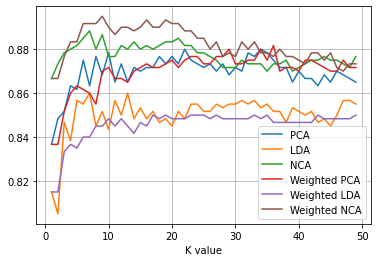

In [7]:
xaxis = range(1,n)
plt.plot(xaxis, res['PCA'], label = 'PCA')
plt.plot(xaxis, res['LDA'], label = 'LDA')
plt.plot(xaxis, res['NCA'], label = 'NCA')
plt.plot(xaxis, res['wPCA'], label = 'Weighted PCA')
plt.plot(xaxis, res['wLDA'], label = 'Weighted LDA')
plt.plot(xaxis, res['wNCA'], label = 'Weighted NCA')
plt.xlabel("K value")
plt.grid(True)
plt.legend()
plt.savefig("../figures/knn2.pdf")